In [1]:
import os, sys
import gc
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
sys.path.append('../')
import torch

In [2]:
from get_algos import get_all_algos , run_experiment ,call_paths, plot_mean

In [3]:
import gym
from gym.wrappers import Monitor
from sb3_contrib import QRDQN ,RecurrentPPO, TRPO 
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_atari_env

In [4]:
env_name='Breakout-v0'

### 2. Evaluation
<ol>
    <li>Create the environment</li>
    <li>For each algorithm:</li>
    <ol><li>Load the model</li>
        <li>Evaluate the model for 5 sample iterations </li>
        <li>Output the score  for each algo and each iteration</li>
        <li>Assess stability of the model based on the variance / standard deviation </li>
    </ol>
    <li>Plot the corresponding scores</li>
</ol> 

In [5]:
env_recurrent_type={'Discrete':['MaskablePPO', 'QRDQN', 'RecurrentPPO', 'TRPO'],'Box':['ARS', 'RecurrentPPO', 'TQC', 'TRPO'], 
                    'MultiDiscrete':['MaskablePPO', 'RecurrentPPO', 'TRPO'],'MultiBinary':['MaskablePPO', 'RecurrentPPO', 'TRPO']}
def get_algo_recurrent(env):
    act_space=str(type(env.action_space)).split('.')[3].split("'")[0]
    return env_recurrent_type[act_space]

algo_list=get_algo_recurrent(gym.make(env_name))
algo_list.remove('MaskablePPO') if 'MaskablePPO' in algo_list else algo_list
print(algo_list)

['QRDQN', 'RecurrentPPO', 'TRPO']


In [6]:
def evaluate_experiment(algo_list, env_name,n_steps=200000,n_episodes=100):
    rewards_mean={}
    rewards_std={}
    for algo_name in reversed(algo_list):
        if algo_name =='QRDQN' or 'TRPO':
            device='cpu'
        else:
            device='cuda' #GPU was unable to load the entire experience relay so moved to virtual memory on disk
        policy='CnnLstmPolicy' if algo_name=='RecurrentPPO' else 'CnnPolicy'   
        env=make_atari_env(env_name,n_envs=6)
        env=VecFrameStack(env, n_stack=6)
        print('******* Evaluating', algo_name,' *******')
        log_path, render_path, model_path=call_paths(algo_name,env_name,n_steps)
        model_name=env_name+"_"+algo_name+"_model"
        model=eval(algo_name).load(os.path.join(model_path,model_name),env,device=device)
        mean_rew, mean_std=evaluate_policy(model,env, n_eval_episodes=n_episodes)
        rewards_mean[algo_name]=mean_rew
        rewards_std[algo_name]=mean_std
        print('Mean rewards for ',n_episodes, ' episodes of ',algo_name,' is ',mean_rew,'\n')
        del model
        env.close()
    return rewards_mean,rewards_std

In [7]:
rewards=evaluate_experiment(algo_list, env_name)

******* Evaluating TRPO  *******
Wrapping the env in a VecTransposeImage.
Mean rewards for  100  episodes of  TRPO  is  2.06 

******* Evaluating RecurrentPPO  *******
Wrapping the env in a VecTransposeImage.
Mean rewards for  100  episodes of  RecurrentPPO  is  4.39 

******* Evaluating QRDQN  *******
Wrapping the env in a VecTransposeImage.


E:\Anaconda\envs\ai_gym\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 84.69GB > 10.70GB
  "This system does not have apparently enough memory to store the complete "


Mean rewards for  100  episodes of  QRDQN  is  2.12 



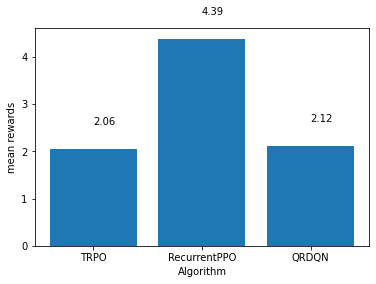

In [8]:
plot_mean(rewards[0],'mean rewards')

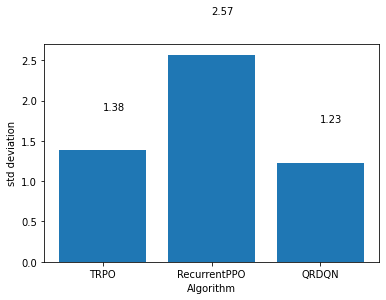

In [9]:
plot_mean(rewards[1],'std deviation')

Hence, we see that:
<ol><li> RecurrentPPO has the highest rewards (2.1x TRPO and 2x QRDQN)  </li>
    <li> It also has the highest std deviation (1.8x TRPO and 2X QRDQN) </li>
    <li> Similarly, A2C has 9% higher reward than PPO but 1.3X its std deviation </li>
    
<b>Given that ReccurrentPPO seems to be the highest rewards we will use it for the next set of 5,000,000 steps